In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Requirements**

In [2]:
# !pip install statsmodels==0.12.2

# import statsmodels
# statsmodels.__version__

### **ARIMA**

In [3]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime


def arima_test(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    long_ep = predictions[i]
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-04-27 BTCUSDT.xlsx', '2021-04-27 ETHUSDT.xlsx', '2021-04-27 BCHUSDT.xlsx', '2021-04-27 XRPUSDT.xlsx', '2021-04-27 EOSUSDT.xlsx', '2021-04-27 LTCUSDT.xlsx', '2021-04-27 ETCUSDT.xlsx', '2021-04-27 LINKUSDT.xlsx', '2021-04-27 XLMUSDT.xlsx', '2021-04-27 ADAUSDT.xlsx', '2021-04-27 XMRUSDT.xlsx', '2021-04-27 SXPUSDT.xlsx', '2021-04-27 KAVAUSDT.xlsx', '2021-04-27 BANDUSDT.xlsx', '2021-04-27 DASHUSDT.xlsx', '2021-04-27 ZECUSDT.xlsx', '2021-04-27 XTZUSDT.xlsx', '2021-04-27 BNBUSDT.xlsx', '2021-04-27 ATOMUSDT.xlsx', '2021-04-27 ONTUSDT.xlsx', '2021-04-27 IOTAUSDT.xlsx', '2021-04-27 BATUSDT.xlsx', '2021-04-27 NEOUSDT.xlsx', '2021-04-27 QTUMUSDT.xlsx', '2021-04-27 WAVESUSDT.xlsx', '2021-04-27 MKRUSDT.xlsx', '2021-04-27 SNXUSDT.xlsx', '2021-04-27 DOTUSDT.xlsx', '2021-04-27 THETAUSDT.xlsx', '2021-04-27 ALGOUSDT.xlsx', '2021-04-27 KNCUSDT.xlsx', '2021-04-27 ZRXUSDT.xlsx', '2021-04-27 COMPUSDT.xlsx', '2021-04-27 OMGUSDT.xlsx']


### **Model**

In [5]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# %tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    # net = layers.LSTM(32, return_sequences=False)(visible)
    net = layers.LSTM(10, return_sequences=False)(visible)

    # net = layers.Dense(32)(visible)
    # net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.BatchNormalization()(net)

    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    net = layers.Dense(128)(net)
    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(256)(net)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    net = layers.BatchNormalization()(net)


    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    # net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dropout(0.3)(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    print(model.summary())
    
    return model

In [10]:
print(keras.__version__)
print(tf.__version__)

2.4.3
2.4.1


### **Data Stacking**

In [ ]:
def resize_npy(x):

  temp_x = []

  for d_i, data in enumerate(x):
    # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
    # resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
    data = data.repeat(2, axis=0).repeat(2, axis=1)
    # resized_data = data.repeat(1, axis=0).repeat(1, axis=1)
    # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
    
    if d_i == 0:
      plt.imshow(data)
      plt.show()
      # plt.imshow(resized_data)
      # plt.show()
    # print('resized_data.shape :', resized_data.shape)
    # break
    temp_x.append(data)

  return temp_x

In [7]:
def min_max_scale(npy_x):

  return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))

start_stamp : 0
x series loaded !
pr series loaded !
y_train[:5] : [[0]
 [1]
 [0]
 [0]
 [0]]
y_train.dtype : int64
x_train.shape : (10485, 45, 7)
x_test.shape : (3496, 45, 7)
x_val.shape : (3495, 45, 7)
y_train.shape : (10485, 1)
y_test.shape : (3496, 1)
y_val.shape : (3495, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([5912, 4573])) [1.2928056 1.       ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([1940, 1555])) [1.24758842 1.        ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([1949, 1547])) [1.25985779 1.        ]
class_weights : {0: 0.886755751014885, 1: 1.1464027990378307}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_test)) : False
y_train_ohe.shape : (10485, 2)
y_val_ohe.shape : (3495, 2)
y_test_ohe.shape : (3496, 2)
test_result.shape : (3496, 2)
y_test[:5] : [1 0 0 0 1]
y_score[:5] : [[0.62

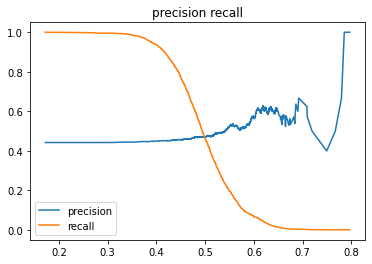

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:714: RuntimeWarning: invalid value encountered in long_scalars


acc_pr_bythr : [2.1262867e-05, 2.1009373e-05, 2.0949976e-05, 2.1035592e-05, 2.1281492e-05, 2.122966e-05, 2.0843238e-05, 2.0516154e-05, 2.0298341e-05, 2.0684967e-05, 2.08419e-05, 2.1063022e-05, 2.1196556e-05, 2.1812406e-05, 2.2586426e-05, 2.290538e-05, 2.3216415e-05, 2.1374162e-05, 2.1522957e-05, 2.1684256e-05, 2.2349668e-05, 2.2815077e-05, 2.3338534e-05, 2.2069684e-05, 2.3205686e-05, 2.3086808e-05, 2.3151302e-05, 2.4045425e-05, 2.4444658e-05, 2.4917877e-05, 2.5485848e-05, 2.5806055e-05, 2.6153375e-05, 2.7040289e-05, 2.649932e-05, 2.672809e-05, 2.6887019e-05, 2.712567e-05, 2.7314898e-05, 2.7739574e-05, 2.7785927e-05, 2.7539509e-05, 2.8001745e-05, 2.7777049e-05, 2.7926124e-05, 2.83531e-05, 2.753665e-05, 2.7547621e-05, 2.7588902e-05, 2.869053e-05, 2.9034092e-05, 2.8435039e-05, 2.9235089e-05, 2.9639581e-05, 2.9433588e-05, 2.7986984e-05, 2.7864136e-05, 2.8649847e-05, 2.913728e-05, 2.9350358e-05, 2.9224657e-05, 2.9217976e-05, 2.886031e-05, 2.927261e-05, 2.9995444e-05, 3.007227e-05, 2.9478831

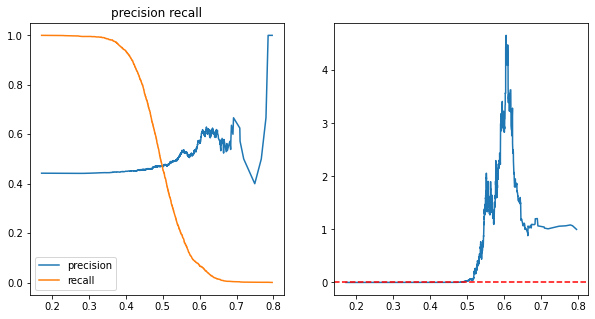

In [12]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from funcs_indicator import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

long_index = 0
leverage = 5
prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue


  # if '02-11' not in candis[i]:  # <-- 04-08 includes all timestamp range
  #   continue  

  # if 'eth'.upper() not in candis[i]:
  #   continue

  # if 'neo'.upper() not in candis[i]:
  #   continue

  # plt.figure(figsize=(35, 10))
  # plt.suptitle('%s %s' % (interval, keys))


  #         get tp parameter        #

  # plt.subplot(1,10,3)
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['ap_list'])
  #   argmax = np.argmax(profit_result_dict[key]['ap_list'][:, [long_index]])
  #   peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(peak_tp, linestyle='--')
  #   # plt.title('acc profit, max at %.4f' % (peak_tp))  

  # plt.subplot(1,10,4)
  # plt.title('max acc profit by leverage')  
  # for key in keys:  
  #   # plt.plot(profit_result_dict[key]['tp_list'], profit_result_dict[key]['max_ap_list'], label=key)
  #   argmax = np.argmax(profit_result_dict[key]['max_ap_list'][:, [long_index]])
  #   max_peak_tp = profit_result_dict[key]['tp_list'][argmax]
  #   # plt.axvline(max_peak_tp, linestyle='--')
  #   # plt.title('max acc profit, max at %.4f' % (max_peak_tp))  


  for key in keys:  

    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      # ohlcv = load_dict[key]['ohlcv']

    if 'eth'.upper() not in key:
      continue

    trial_number = 2
    period = 45
    
  #   ohlcv = pd.read_excel(date_path + key, index_col=0)
  #   print('len(ohlcv) :', len(ohlcv))


  #   #       select timestamp range      #
  #   # time_index = ohlcv.index
  #   # total_stamp = list(map(lambda x: datetime.timestamp(x), time_index)) 

  #   # rm_index_amt = np.sum(np.array(total_stamp) < start_stamp)

  #   # ohlcv = ohlcv.iloc[rm_index_amt:]
  #   # print(ohlcv.head())

  #   # ohlcv = ohlcv.iloc[:-int(len(ohlcv) * 0.3)]  # exclude back_range
  #   # predictions = load_dict[key]['predictions']
  #   # err_ranges = load_dict[key]['err_ranges']
  #   print("ohlcv.index[0] :", ohlcv.index[0])
  #   print("ohlcv.index[-1] :", ohlcv.index[-1])

  #   predictions = ohlcv['close'].shift(1).values
  #   err_ranges = np.zeros_like(predictions)

  #   # leverage_list = profit_result_dict[key]['leverage_list']
  #   # temp_ap_list = list()
  #   # temp_pr_list = list()

  #   try:
  #     print('-------------- %s --------------' % key)
  #     result = get_back_result(ohlcv, predictions, err_ranges, tp=0, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
  #     # temp_ap_list.append(result[2])
  #     # temp_pr_list.append(result[3])

  #     # if round(leverage) == 1:
  #     #   temp_pr_list = result[3]
  #     pr_list = result[3][long_index]

  #   except Exception as e:
  #     print(e)
  #     break    


    
  # # break
  #   #         clustering zone           #

  #   #       set data features : ohlc, v, ep
  #   time_index = ohlcv.index[-len(predictions):]

  #   sliced_ohlcv = ohlcv[-len(predictions):]

  #   #       scale with price    #
  #   ohlc = ohlcv.iloc[-len(predictions):, :4]      
  #   long_ep = np.array(predictions)
  #   long_ep = long_ep.reshape(-1, 1)
  #   ha_ohlc = heikinashi(sliced_ohlcv).iloc[:, :4]
  #   sar = lucid_sar(sliced_ohlcv)
  #   ema1, ema2, ema3 = ema_ribbon(sliced_ohlcv)
  #   senkou1, senkou2 = ichimoku(sliced_ohlcv)

  #   #     min max scale   #
  #   vol = sliced_ohlcv.iloc[-len(predictions):, [4]]

  #   #     scale with baseline   #
  #   #     방법 1. 전체 기간 min_max scaling   #
  #   cbo, ema_cbo = cct_bbo(sliced_ohlcv, 21, 13) 

  #   _, _, bbw = bb_width(sliced_ohlcv, 20, 2) 
    
  #   fish = fisher(sliced_ohlcv, 60)
  #   trix = trix_hist(sliced_ohlcv, 14, 1, 5) 
  #   rsi_ = rsi(sliced_ohlcv)
  #   macd_hist = macd(sliced_ohlcv)




  #   # ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
  #   # ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
  #   # ohlcv['body'] = ohlcv['close'] / ohlcv['open']
  #   # candle = ohlcv.iloc[-len(predictions):, -3:]


  #   print('len(ohlc) :', len(ohlc))
  #   print('long_ep.shape :', long_ep.shape)
  #   print('len(ha_ohlc) :', len(ha_ohlc))
  #   print('len(sar) :', len(sar))
  #   print('len(ema1) :', len(ema1))
  #   print('len(senkou1) :', len(senkou1))
  #   print('len(cbo) :', len(cbo))
  #   print('len(ema_cbo) :', len(ema_cbo))
  #   print('len(bbw) :', len(bbw))
  #   print('len(fish) :', len(fish))
  #   print('len(trix) :', len(trix))
  #   print('len(rsi_) :', len(rsi_))
  #   print('len(macd_hist) :', len(macd_hist))


  #   # break


  #   #       set params    #
  #   period = 45
  #   key_i = i

  #   # plt.plot(cbo)
  #   # plt.plot(bbw)
  #   plt.plot(fish, color='b')
  #   # plt.plot(trix)
  #   # plt.plot(rsi_)
  #   # plt.plot(macd_hist)
  #   plt.show()

  #   #      global scaling   #
  #   min_max = MinMaxScaler()
  #   cbo = min_max.fit_transform(cbo.values.reshape(-1, 1))
  #   ema_cbo = min_max.fit_transform(ema_cbo.values.reshape(-1, 1))
  #   bbw = min_max.fit_transform(bbw.values.reshape(-1, 1))
  #   fish = min_max.fit_transform(fish.values.reshape(-1, 1))
  #   trix = min_max.fit_transform(trix.values.reshape(-1, 1))
  #   rsi_ = min_max.fit_transform(rsi_.values.reshape(-1, 1))
  #   macd_hist = min_max.fit_transform(macd_hist.values.reshape(-1, 1))

  #   # plt.plot(cbo)
  #   # plt.plot(bbw)
  #   plt.plot(fish, color='r')
  #   # plt.plot(trix)
  #   # plt.plot(rsi_)
  #   # plt.plot(macd_hist)
  #   plt.show()
  #   # break

  #   plotting = True

  #   for trial_number in range(13):

  #     data_x, data_pr, data_updown = [], [], []
  #     data_index = []

  #     for i in range(period, len(predictions)):

  #       #   pr_list != 1 인 데이터만 사용한다
  #       # if 1:
  #       if pr_list[i] != 1:

  #         min_max = MinMaxScaler()
          
  #         #   prediction 을 제외한 이전 데이터를 사용해야한다
  #         temp_ohlc = ohlc.iloc[i - period : i].values
  #         temp_long_ep = long_ep[i - period : i]          
  #         temp_ha_ohlc = ha_ohlc.iloc[i - period : i].values
  #         temp_sar = sar.iloc[i - period : i].values.reshape(-1, 1)
  #         temp_ema1 = ema1.iloc[i - period : i].values.reshape(-1, 1)
  #         temp_ema2 = ema2.iloc[i - period : i].values.reshape(-1, 1)
  #         temp_ema3 = ema3.iloc[i - period : i].values.reshape(-1, 1)
  #         temp_senkou1 = senkou1.iloc[i - period : i].values.reshape(-1, 1)
  #         temp_senkou2 = senkou2.iloc[i - period : i].values.reshape(-1, 1)          

  #         price_data = np.hstack((temp_ohlc, temp_long_ep, temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2))

  #         if np.isnan(np.sum(price_data)):
  #           continue

  #         # print("price_data[:10] :", price_data[:10])
  #         # print("temp_ohlc.shape :", temp_ohlc.shape)
  #         # print("temp_long_ep.shape :", temp_long_ep.shape)
  #         # print("temp_ha_ohlc.shape :", temp_ha_ohlc.shape)
  #         # print("price_data.shape :", price_data.shape)

  #         if plotting:
  #           plt.plot(price_data)
  #           plt.show()

  #         temp_price_data = min_max_scale(price_data)
  #         # temp_price_data = (price_data - np.min(price_data)) / (np.max(price_data) - np.min(price_data))

  #         temp_ohlc = temp_price_data[:, :4]
  #         temp_long_ep = temp_price_data[:, [4]]
  #         temp_ha_ohlc = temp_price_data[:, 5:9]
  #         temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2 = np.split(temp_price_data[:, 9:], 6, axis=1)

  #         if plotting:

  #           plt.plot(temp_price_data)
  #           plt.show()

  #           plotting = False
  #         # break

  #         #   vol -> min_max
  #         temp_vol = min_max.fit_transform(vol.iloc[i - period : i].values.reshape(-1, 1))
          
  #         # temp_candle = candle.iloc[i - period : i].values

  #         temp_cbo = cbo[i - period : i]
  #         temp_ema_cbo = ema_cbo[i - period : i]
  #         temp_bbw = bbw[i - period : i]
  #         temp_fish = fish[i - period : i]
  #         temp_trix = trix[i - period : i]
  #         temp_rsi_ = rsi_[i - period : i]
  #         temp_macd_hist = macd_hist[i - period : i]

  #         # print(temp_ohlc.shape)
  #         # print(temp_long_ep.shape)
  #         # print(temp_vol.shape)
  #         # print(temp_candle.shape)
  #         # break

  #         trial_list = [temp_ha_ohlc, temp_sar, temp_ema1, temp_ema2, temp_ema3, temp_senkou1, temp_senkou2,
  #                       temp_cbo, temp_ema_cbo, temp_bbw, temp_fish, temp_trix, temp_rsi_, temp_macd_hist]

  #         # trial_list = [temp_ohlc[:, [0], temp_ohlc[:, [1], temp_ohlc[:, [2], temp_ohlc[:, [3]], temp_vol, temp_ema_cbo]

  #         #                   feature selection                   #  
  #         # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
  #         # temp_data = trial_list[trial_number]
  #         temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, trial_list[trial_number]))
  #         # temp_data = np.hstack((temp_ohlc, temp_vol))

  #         #     only close    #
  #         # temp_data = temp_ohlc[:, [-1]]

  #         # temp_data = temp_ohlc

  #         #     only volume    #
  #         # temp_data = temp_vol

  #         # temp_data = np.hstack((temp_ohlc, temp_long_ep))
  #         # temp_data = temp_vol

  #         #   scaler 설정

  #         #   ohlc & ep -> max_abs
  #         # max_abs = MaxAbsScaler()
  #         # temp_data[:, :-1] = max_abs.fit_transform(temp_data[:, :-1])

          
  #         # min_max = MinMaxScaler()
  #         # temp_data = min_max.fit_transform(temp_data)

  #         #   candle -> max_abs    
  #         # max_abs = MaxAbsScaler()
  #         # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

  #         # min_max = MinMaxScaler()
  #         # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

  #         if np.isnan(np.sum(temp_data)):
  #           continue

  #         data_x.append(temp_data)
  #         data_pr.append(pr_list[i])
  #         data_index.append(time_index[i])
  #         data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


  #     print('np.array(data_x).shape :', np.array(data_x).shape)
  #     # print(data_x[0])


  #     #       Reshape data for image deep - learning     #
  #     _, row, col = np.array(data_x).shape

  #     # input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)
  #     input_x = np.array(data_x).reshape(-1, row, col).astype(np.float32)

  #     #     1c to 3c    #
  #     # input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]
  #     # input_x = np.array(resize_npy(input_x))


  #     input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
  #     input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
  #     input_index = np.array(data_index).reshape(-1, 1)
  #     print('input_x.shape :', input_x.shape)
  #     print('input_x.dtype :', input_x.dtype)
  #     print('input_pr.shape :', input_pr.shape)
  #     print('input_ud.shape :', input_ud.shape)
  #     print('input_index.shape :', input_index.shape)


  #     # x_train_, x_test, pr_train_, pr_test, ud_train_, ud_test = train_test_split(input_x, input_pr, input_ud, test_size=0.4, shuffle=False, random_state=random_state)
  #     # x_train, x_val, pr_train, pr_val, ud_train, ud_val = train_test_split(x_train_, pr_train_, ud_train_, test_size=0.25, shuffle=False, random_state=random_state)

  #     #     do stacking   #
  #     # if prev_x is None:
  #     prev_x = input_x
  #     prev_pr = input_pr
  #     prev_ud = input_ud
  #     prev_index = input_index

  #     total_x = input_x
  #     total_pr = input_pr
  #     total_ud = input_ud
  #     total_index = input_index

  #     # else:
  #     #   total_x = np.vstack((prev_x, input_x))
  #     #   total_pr = np.vstack((prev_pr, input_pr))
  #     #   total_ud = np.vstack((prev_ud, input_ud)) 
  #     #   total_index = np.vstack((prev_index, input_index)) 

  #     #   prev_x = total_x
  #     #   prev_pr = total_pr
  #     #   prev_ud = total_ud
  #     #   prev_index = total_index

  #     print('total_x.shape :', total_x.shape)
  #     print('total_pr.shape :', total_pr.shape)
  #     print('total_ud.shape :', total_ud.shape)
  #     print('prev_index.shape :', prev_index.shape)

      
  #     # _, row, col, _ = input_x.shape
  #     _, row, col = input_x.shape

  #     #       split new test      #

  #     seed = 1
  #     random_state = 201
  #     np.random.seed(seed)
  #     from sklearn.model_selection import train_test_split


  #     #         get unique timestamp      #
  #     print(np.unique(total_index, return_counts=True))
  #     uniq_stamp = np.unique(total_index)

  #     stamp_train_, stamp_test = train_test_split(uniq_stamp, test_size=0.2, shuffle=False, random_state=random_state)
  #     stamp_train, stamp_val = train_test_split(stamp_train_, test_size=0.25, shuffle=True, random_state=random_state)

  #     print("stamp_train.shape :", stamp_train.shape)
  #     print("stamp_val.shape :", stamp_val.shape)
  #     print("stamp_test.shape :", stamp_test.shape)
  #     # break


  #     #         split data by stamp     #
  #     x_train, x_val, x_test = [], [], []
  #     pr_train, pr_val, pr_test = [], [], []
  #     index_train, index_val, index_test = [], [], []


  #     from tqdm.notebook import tqdm

  #     np.random.shuffle(total_index)

  #     for i in tqdm(range(len(total_index))):

  #       if total_index[i] in stamp_train:
  #         x_train.append(total_x[i])
  #         pr_train.append(total_pr[i])
  #         index_train.append(total_index[i])

  #       elif total_index[i] in stamp_val:
  #         x_val.append(total_x[i])
  #         pr_val.append(total_pr[i])
  #         index_val.append(total_index[i])
        
  #       elif total_index[i] in stamp_test:
  #         x_test.append(total_x[i])
  #         pr_test.append(total_pr[i])
  #         index_test.append(total_index[i])


  #     x_train = np.array(x_train)
  #     x_val = np.array(x_val)
  #     x_test = np.array(x_test)

  #     pr_train = np.array(pr_train)
  #     pr_val = np.array(pr_val)
  #     pr_test = np.array(pr_test)

  #     index_train = np.array(index_train)
  #     index_val = np.array(index_val)
  #     index_test = np.array(index_test)
        
  #     print("x_train.shape :", x_train.shape) # x_train.shape : (3807, 90, 12, 3)
  #     print("x_val.shape :", x_val.shape) # x_train.shape : (3807, 90, 12, 3)
  #     print("x_test.shape :", x_test.shape) # x_train.shape : (3807, 90, 12, 3)

  
    symbol_name = key.split(' ')[1].split('.')[0]

    x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_trial_%s_timesplit.npy' % (period, trial_number)
    x_train = np.load(x_save_path)
    x_val = np.load(x_save_path.replace('x_train', 'x_val'))
    x_test = np.load(x_save_path.replace('x_train', 'x_test'))
    print('x series loaded !')


    pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_trial_%s_timesplit.npy' % (period, trial_number)
    pr_train = np.load(pr_save_path)
    pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
    pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
    # np.save(pr_save_path.replace('pr_train', 'new_input_pr'), new_input_pr)
    print('pr series loaded !')

    
    _, row, col, = x_train.shape

    #         pr label   #
    y_train = np.where(pr_train > 1, 1, 0)
    y_test = np.where(pr_test > 1, 1, 0)
    y_val = np.where(pr_val > 1, 1, 0)


    seed = 1
    random_state = 20
    np.random.seed(seed)
    # tf.random.set_seed(seed)

    #         up label      #
    # y_train = np.where(ud_train > 1, 1, 0)
    # y_test = np.where(ud_test > 1, 1, 0)
    # y_val = np.where(ud_val > 1, 1, 0)

    # print('pr_train[:5] :', pr_train[:5])
    # print('ud_train[:5] :', ud_train[:5])
    print('y_train[:5] :', y_train[:5])
    print('y_train.dtype :', y_train.dtype)

    print('x_train.shape :', x_train.shape)
    print('x_test.shape :', x_test.shape)
    print('x_val.shape :', x_val.shape)
    print('y_train.shape :', y_train.shape)
    print('y_test.shape :', y_test.shape)
    print('y_val.shape :', y_val.shape)

    def class_ratio(in_list):

      return in_list / in_list[1]

    print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
    print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
    print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

    label = y_train.reshape(-1, )
    class_weights = class_weight.compute_class_weight('balanced', 
                                                        classes=np.unique(label),
                                                        y=label)
    class_weights = dict(enumerate(class_weights))
    print('class_weights :', class_weights)

    # sample_weight = np.ones(shape=(len(y_train),))
    # sample_weight[(y_train == 1).reshape(-1,)] = 1.5
    # print('sample_weight[:20] :', sample_weight[:20])


    print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
    print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
    print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

    print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
    print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
    print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

    y_train_ohe = np_utils.to_categorical(y_train, num_classes)
    y_val_ohe = np_utils.to_categorical(y_val, num_classes)
    y_test_ohe = np_utils.to_categorical(y_test, num_classes)
    print('y_train_ohe.shape :', y_train_ohe.shape)
    print('y_val_ohe.shape :', y_val_ohe.shape)
    print('y_test_ohe.shape :', y_test_ohe.shape)


    ckpt_path = current_path + 'ckpt/'
    board_path = current_path + 'graph/'
    # model_name = 'classifier_%s_close_updown_pr_theta_shuffle_without_back_03.h5' % period
    # model_name = 'classifier_%s_close_updown_pr_theta_train_prevdata_005.h5' % period

    # model_name = 'classifier_%s_close_updown_pr_theta_train_evendata_shuffle2_300k.h5' % period
    # model_name = 'classifier_%s_lstm_close_updown_pr_neo_re_tf1_timesplit.h5' % period
    # model = keras.models.load_model(ckpt_path + model_name)

    batch_size = 512
    # _, row, col, = x_train.shape
    # print("row, col :", row, col)

    model_name = 'classifier_%s_lstm_close_updown_pr_trial_%s_tf2_timesplit.h5' % (period, trial_number)
    # model_name = 'classifier_%s_lstm_close_updown_pr_trial_%s_timesplit.h5' % (period, trial_number)


    # model = FER_Model(input_shape=(row, col))
    # opt = Adam(lr=0.00001, decay=0.000005)
    # # opt = Adam(lr=0.001, decay=0.0005)
    # model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # # model_name = 'classifier_%s_close_updown_pr_all_pair_shuffle_300k_timesplit.h5' % period
    # # model_name = 'classifier_%s_lstm_close_updown_pr_neo_re_tf1_timesplit.h5' % period
    # # model_name = 'classifier_%s_lstm_close_updown_pr_eth_abs_timesplit.h5' % period
    # # model_name = 'classifier_%s_lstm_close_updown_pr_neo_abs_timesplit.h5' % period



    # checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    # checkpoint2 = TensorBoard(log_dir=board_path,
    #                           histogram_freq=0,
    #                           write_graph=True,
    #                           write_images=True)
    # checkpoint3 = EarlyStopping(monitor='val_loss', patience=250)
    # callbacks_list = [checkpoint, checkpoint2, checkpoint3]
    # # callbacks_list = [checkpoint, checkpoint2]

    # # keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

    # # we iterate 200 times over the entire training set
    # num_epochs = 1000                    

    # history = model.fit(x_train, y_train_ohe,
    #                     steps_per_epoch=int(len(x_train) / batch_size), 
    #                     epochs=num_epochs,  
    #                     verbose=2,  
    #                     callbacks=callbacks_list,
    #                     class_weight=class_weights,
    #                     validation_data=(x_val, y_val_ohe),  
    #                     validation_steps=int(len(x_val) / batch_size),
    #                     shuffle=False)
    
    ckpt_path = current_path + 'ckpt/'
    board_path = current_path + 'graph/'
    # model_name = 'classifier_45_close_updown_pr_theta_non_shuffle_ex_02008.h5'
    # model_name = 'classifier_45_close_updown_pr_theta.h5'
    # model_name = 'classifier_45_close_updown_pr_theta_train_evendata_shuffle2_300k.h5'
    # model_name = 'classifier_45_lstm_close_updown_pr_neo_timesplit.h5'

    # model_name = 'classifier_45_lstm_close_updown_pr_eth_timesplit.h5'

    model = keras.models.load_model(ckpt_path + model_name)

    # x_test = new_input_x
    # y_test = np.where(new_input_pr > 1, 1, 0)
    # pr_test = new_input_pr

    # x_test = org_x_test
    # y_test = org_y_test
    # pr_test = org_pr_test

    # x_test = x_train
    # y_test = y_train
    # pr_test = pr_train

    # x_test = x_val
    # y_test = y_val
    # pr_test = pr_val

    # x_test = concat_x
    # y_test = np.where(concat_pr > 1, 1, 0)
    # pr_test = concat_pr

    test_result = model.predict(x_test)
    # test_result = model.predict(test_set)

    print('test_result.shape :', test_result.shape)
    # print('pr_val.shape :', pr_val.shape)

    y_score = test_result[:, [1]]
    print('y_test[:5] :', y_test.reshape(-1,)[:5])
    # print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
    print('y_score[:5] :', y_score[:5])
    # print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

    print('y_test.shape :', y_test.shape)
    print('y_score.shape :', y_score.shape)

    print('len(y_test) :', len(y_test))

    #     precision recall curve   #
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    precision, recall = precision[:-1], recall[:-1]

    plt.plot(threshold, precision, label='precision')
    plt.plot(threshold, recall, label='recall')
    plt.legend()
    plt.title('precision recall')
    plt.show()
    # print(y_pred)


    # threshold = [0.65]
    # print('threshold :', threshold)
    # break

    acc_pr_bythr = []
    new_thresh = []

    for thresh in threshold:
      
      # if thresh < 0.5:
      #     continue

      y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
      # print('y_pred.shape :', y_pred.shape)
      # print('y_pred :', y_pred)

      #     compare precision     #

      # print('precision :', precision_score(y_test, y_pred))
      # print('recall :', recall_score(y_test, y_pred))
      # print()

      # print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
      # print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

      # # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
      # # plt.show()  
      # print()

      #     check win-ratio improvement     #
      cmat = confusion_matrix(y_test, y_pred)
      # print(cmat)
      # print(np.sum(cmat, axis=1))

      test_size = len(y_test)
      test_pr_list = pr_test
      # print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

      org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
      ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
      # print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

      # print('pr_test.shape :', pr_test.shape)

      # print(y_pred)
      # print(test_pr_list)
      pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
      pred_pr_list = np.where(np.isnan(pred_pr_list), 1.0, pred_pr_list)
      pred_pr_list = np.where(pred_pr_list == 0.0, 1.0, pred_pr_list)
      # print('pred_pr_list.shape :', pred_pr_list.shape)

      # if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
      #   print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
      #   print('thresh :', thresh)
        
      # if len(threshold) == 1:
    #   plt.figure(figsize=(10, 5))
    #   plt.subplot(121)
    #   plt.plot(np.cumprod(test_pr_list))
    #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
    # # plt.show()

    #   plt.subplot(122)
    #   plt.plot(np.cumprod(pred_pr_list))
    #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
    #   # plt.axvline(len(org_pr_test), linestyle='--', color='r')
    #   plt.show()


      acc_pr_bythr.append(np.cumprod(pred_pr_list)[-1])
      new_thresh.append(thresh)


    print('acc_pr_bythr :', acc_pr_bythr)

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(threshold, precision, label='precision')
    plt.plot(threshold, recall, label='recall')
    plt.legend()
    plt.title('precision recall')
    # plt.show()
    plt.subplot(122)
    plt.plot(new_thresh, acc_pr_bythr)
    plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
    plt.show()


  # break # --> use only one pair dataset

  #         chunks 로 나누지 않아도, generator 에서 batch_size 만큼만 load 할 것   #
  try:
    if len(total_x) > 300000:
      break
  except:
    pass

  
        

### Check shuffled index

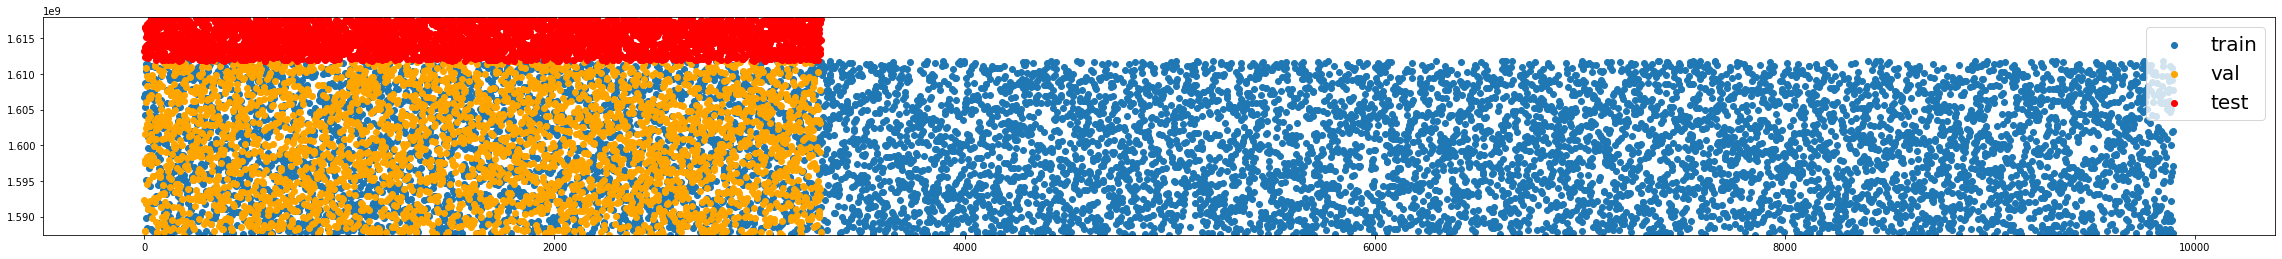

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

### Load Data

In [ ]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_neo_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_neo_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


### **Data Split**

### **Training**

In [ ]:
org_x_test = x_test
org_y_test = y_test
org_pr_test = pr_test

In [ ]:
x_test = org_x_test
y_test = org_y_test
pr_test = org_pr_test

In [ ]:
concat_x = np.vstack((org_x_test, new_input_x))
concat_y = np.vstack((org_y_test, np.where(new_input_pr > 1, 1, 0)))
concat_pr = np.vstack((org_pr_test, new_input_pr))

In [ ]:
x_test = new_input_x
y_test = np.where(new_input_pr > 1, 1, 0)
pr_test = new_input_pr

In [ ]:
# print(pred_pr_list)
for pr in pred_pr_list:
  if pr != 1:
    print(pr)

In [ ]:
plt.figure(figsize=(50, 5))
plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test):len(org_pr_test) + 10])
# plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test) - 10:len(org_pr_test) + 10])
plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
# plt.axvline(len(org_pr_test), linestyle='--', color='r')
plt.show()

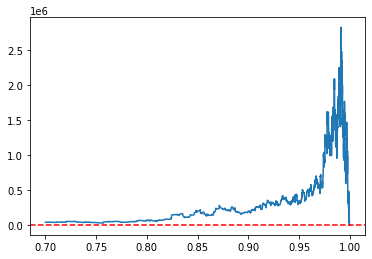

In [ ]:
# plt.show()
# plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

